In [1]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["font.family"] = "monospace"

In [2]:
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024

STEP_PATTERN = r"step:([0-9]+)/([0-9]+)"
VAL_LOSS_PATTERN = r"val_loss:([0-9.]+)"
TRAIN_TIME_PATTERN = r"train_time:([0-9]+)ms"

In [38]:
IMAGES_SAVE_PATH = "."

log_groups = {
    "11/24 record, 1750 steps, 8xH100": [
        "../112424_WindowWarmup/3151f69a-f89e-452c-ac80-b85118007583.txt",
        "../112424_WindowWarmup/4428858e-7cb8-4a25-a936-818d8f28de51.txt",
        "../112424_WindowWarmup/ae732e01-04b2-4665-b570-a77210e73e28.txt",
        "../112424_WindowWarmup/ba299b7e-a36a-4fd8-a268-25bb772010dd.txt",
        "../112424_WindowWarmup/cf9e4571-c5fc-4323-abf3-a98d862ec6c8.txt",
        "../112424_WindowWarmup/d1cf11aa-7b8e-4d28-a94d-1aab632e0f38.txt",
        "../112424_WindowWarmup/dca62101-15d4-4c76-842e-99213fa2508b.txt",
    ],
    "11/24 record, 1750 steps, 4xH100": [
        "112424_4xH100_1750steps/1a67d047-65be-409d-9939-864946612c42.txt",
        "112424_4xH100_1750steps/f50fde53-9295-4f52-a4be-c2093753c0fe.txt",
        "112424_4xH100_1750steps/811e58e7-88db-461a-99c2-dc0330980d52.txt",
        "112424_4xH100_1750steps/aca734c2-674c-4144-bea3-d316f578f2cb.txt",
        "112424_4xH100_1750steps/8ffb93a5-b7d9-43e6-b8dd-7fa4886e66ce.txt",
        "112424_4xH100_1750steps/f0294258-43ff-41c3-8532-ddbd2882b22f.txt",
    ],
    "11/24 record, 1750 steps + Sharded Muon for QK Weights, 4xH100": [
        "112424_4xH100_1750steps_ShardedMuonQK/299ec380-0f32-45ec-8f30-c64cdb56f5ad.txt",
        "112424_4xH100_1750steps_ShardedMuonQK/3d6cbccd-000f-4066-9930-785e6fe18639.txt",
    ],
    "11/24 record, 1750 steps + Sharded Muon for QKV Weights, 4xH100": [
        "112424_4xH100_1750steps_ShardedMuonQKV/1453b508-0c50-4680-8b92-f56a6c54ee43.txt",
        "112424_4xH100_1750steps_ShardedMuonQKV/40ccf112-f0c9-4f83-9229-50bb36763544.txt",
    ],
    "11/24 record, 1700 steps, 4xH100": [
        "112424_4xH100_1700steps/286ef061-4e2a-4d86-a29a-19645d45af72.txt",
        "112424_4xH100_1700steps/7f86d1a9-0b9e-4c74-9c35-0f3027e4fc2a.txt",
        "112424_4xH100_1700steps/c2599aa9-67a0-4cf6-92ec-cc8ce286f7a6.txt",
        "112424_4xH100_1700steps/ccc5078b-5f76-428e-8135-21199691bad8.txt",
    ],
    "11/27 record?? 1700 steps + Att Softcap + HP Tuning, 4xH100": [  # x1.6 QK LR
        "112424_4xH100_1700steps_AttnSoftcap/226ce802-adbd-4d46-800b-067d4555bb90.txt",
        "112424_4xH100_1700steps_AttnSoftcap/dc64f3ef-0049-4442-bf15-204f98a6c957.txt",
    ],
    "11/29 record?? 1750 steps + LayerNorm on QKNorm, 4xH100": [
        "112924_4xH100_1750steps_LayerNorm/41cf0269-13f5-4a51-9892-1c90e9bc271f.txt",
        "112924_4xH100_1750steps_LayerNorm/45476d26-6671-4646-a2ce-1b4f80af32e7.txt",
        "112924_4xH100_1750steps_LayerNorm/e25895ac-7361-4b8f-af57-79e5880949da.txt",
    ],
    # [  # x1.6 QK LR; block size warmup schedule
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/083bfdaf-71da-40b9-b476-87475b369d99.txt",
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/6a46b6df-2351-4878-bf15-209573699aad.txt",
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/7e4ccef3-b333-4371-80bc-81a5ce0a8a3e.txt",
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/b84cb815-0b17-4e42-86b7-e59b647a350a.txt",
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/9ad78b82-277e-4243-b1b7-9138f16f924d.txt",
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/a01268fc-f69b-4337-8fd8-588d82f94a62.txt",
    #     "112424_4xH100_1700steps_AttnSoftcap_BlockSizeWarmup/eb571346-1519-428d-9e14-63ba01f82c3d.txt",
    # ]
}

log_group_to_color_map = {
    "11/24 record, 1750 steps, 8xH100": "Blue",
    "11/24 record, 1750 steps, 4xH100": "Violet",
    "11/24 record, 1750 steps + Sharded Muon for QK Weights, 4xH100": "Orange",
    "11/24 record, 1750 steps + Sharded Muon for QKV Weights, 4xH100": "Yellow",
    "11/24 record, 1700 steps, 4xH100": "Green",
    "11/27 record?? 1700 steps + Att Softcap + HP Tuning, 4xH100": "Red",
    "11/29 record?? 1750 steps + LayerNorm on QKNorm, 4xH100": "Brown",
}

In [39]:
log_group_files = {
    log_group_name: [open(filename, "r").readlines() for filename in log_filenames]
    for log_group_name, log_filenames in log_groups.items()
}

In [40]:
log_group_data = {}

for log_group_name, files in log_group_files.items():
    steps = [[] for _ in range(len(files))]
    val_losses = [[] for _ in range(len(files))]
    train_times = [[] for _ in range(len(files))]
    train_times_min = [[] for _ in range(len(files))]
    train_tokens = [[] for _ in range(len(files))]

    for idx, file in enumerate(files):
        for line in file:
            if line.startswith("step:") and "val_loss:" in line:
                step = re.search(STEP_PATTERN, line).group(1)
                val_loss = re.search(VAL_LOSS_PATTERN, line).group(1)
                train_time = re.search(TRAIN_TIME_PATTERN, line).group(1)
                steps[idx].append(int(step))
                val_losses[idx].append(float(val_loss))
                train_times[idx].append(float(train_time))
        steps[idx] = np.array(steps[idx])
        val_losses[idx] = np.array(val_losses[idx])
        train_times[idx] = np.array(train_times[idx])
        train_times_min[idx] = train_times[idx] / 1000 / 60
        train_tokens[idx] = NUM_DEVICES * BATCH_PER_DEVICE * SEQ_LEN * steps[idx]
    
    log_group_data[log_group_name] = {
        "steps": steps,
        "val_losses": val_losses,
        "train_times": train_times,
        "train_times_min": train_times_min,
        "train_tokens": train_tokens,
    }

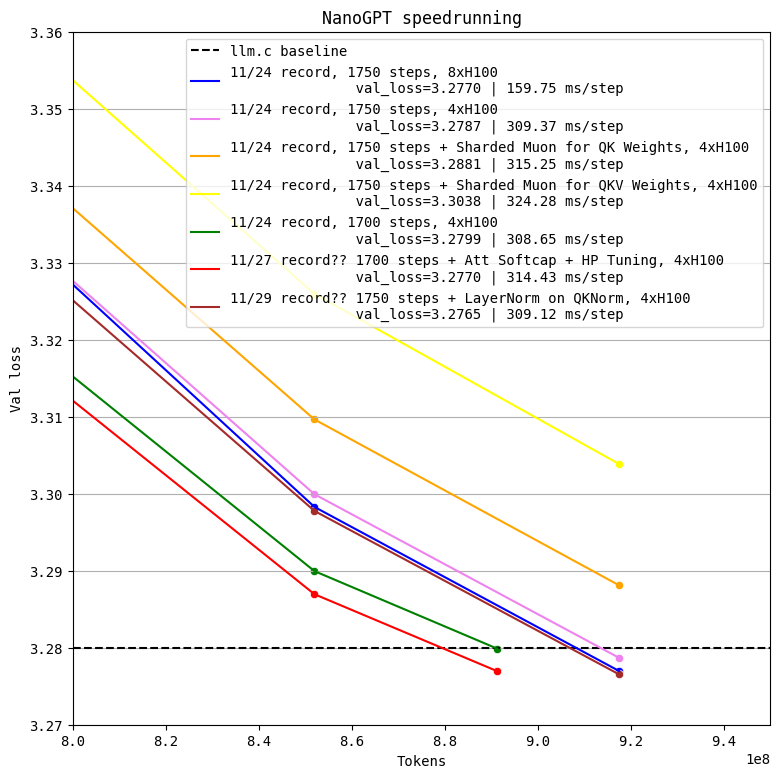

In [41]:
plt.figure(figsize=(9, 9))

sns.lineplot(x=np.linspace(0.8e9, 1.0e9, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

for log_group_name, data in log_group_data.items():
    log_val_losses = np.mean(np.array(data["val_losses"]), 0)
    log_train_tokens = np.mean(np.array(data["train_tokens"]), 0)
    log_train_times = np.mean(np.array(data["train_times"]), 0)
    log_steps = np.mean(np.array(data["steps"]), 0)

    step_avg = log_train_times[-1] / log_steps[-1]
    final_val_loss = log_val_losses[-1]

    sns.scatterplot(x=log_train_tokens, y=log_val_losses, linewidth=0.5, color=log_group_to_color_map[log_group_name])
    label = f"{log_group_name}\n{'':<15}val_loss={final_val_loss:.4f} | {step_avg:.2f} ms/step"
    sns.lineplot(x=log_train_tokens, y=log_val_losses, label=label, color=log_group_to_color_map[log_group_name])

plt.title("NanoGPT speedrunning")
plt.legend(loc="upper right")
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
# plt.xlim(1.2e9, 1.6e9)
plt.xlim(0.8e9, 0.95e9)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("Tokens")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_tokens_112724.png")

In [42]:
hw_step_time_ratio = (
    np.mean(np.array(log_group_data["11/24 record, 1750 steps, 4xH100"]["train_times"])[:,-1])
    / np.mean(np.array(log_group_data["11/24 record, 1750 steps, 8xH100"]["train_times"])[:,-1])
)
hw_step_time_ratio

np.float64(1.9366085757959473)

In [ ]:
plt.figure(figsize=(9, 9))

sns.lineplot(x=np.linspace(0.8e9, 1.0e9, 100), y=[3.28]*100, linestyle="--", color="black", label="llm.c baseline")

for log_group_name, data in log_group_data.items():
    log_val_losses = np.mean(np.array(data["val_losses"]), 0)
    log_train_times_min = np.mean(np.array(data["train_times_min"]), 0)
    log_train_times = np.mean(np.array(data["train_times"]), 0)
    log_steps = np.mean(np.array(data["steps"]), 0)

    if "4xH100" in log_group_name:
        log_train_times_min /= hw_step_time_ratio
        log_train_times /= hw_step_time_ratio

    step_avg = log_train_times[-1] / log_steps[-1]
    final_val_loss = log_val_losses[-1]

    sns.scatterplot(x=log_train_times_min, y=log_val_losses, linewidth=0.5, color=log_group_to_color_map[log_group_name])
    label = (
        f"{log_group_name}\n{'':<15}val_loss={final_val_loss:.4f} | {step_avg:.2f} ms/step [HW Adjusted]"
        if "4xH100" in log_group_name
        else f"{log_group_name}\n{'':<15}val_loss={final_val_loss:.4f} | {step_avg:.2f} ms/step"
    )
    sns.lineplot(x=log_train_times_min, y=log_val_losses, label=label, color=log_group_to_color_map[log_group_name])

plt.title("NanoGPT speedrunning")
plt.legend(loc="upper right")
plt.ylim(3.27, 3.36)
plt.yticks(np.linspace(3.27, 3.36, 10))
# plt.xticks(np.arange(0, 34, 2))
plt.xlim(4, 5)
plt.grid(axis="y")
plt.ylabel("Val loss")
plt.xlabel("[HARDWARE ADJUSTED] Wall-clock Time (Minutes) on 4xH100s")
plt.savefig(f"{IMAGES_SAVE_PATH}/nanogpt_speedrun_wallclock_112724.png")